### CREDIT

This notebook is prepared by the guidance of  Devjyoti Chakraborty's blogs from Pyimagesearch. Most of the code blocks and explanations are taken from these blogs. You can reach original codes and detailed explanations from references.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about Pix2pix by keras and TF. We will implement Pix2Pix GAN for Image Translation for cityscapes dataset hosted by UC Berkeley.


#### Keywords

* Pix2pix
* Image Translation
* GAN
* TF 
* cityscapes

In [25]:
# import the necessary packages
import os

# name of the dataset we will be using 
DATASET = "cityscapes"

# build the dataset URL
DATASET_URL  = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{DATASET}.tar.gz"

# define the batch size
# train batch size can be increased
TRAIN_BATCH_SIZE = 16
INFER_BATCH_SIZE = 8

# dataset specs
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

# training specs
LEARNING_RATE = 2e-4
EPOCHS = 150
STEPS_PER_EPOCH = 50

# path to the base output directory
BASE_OUTPUT_PATH = "outputs"

# path to the pix2pix generator paths
GENERATOR_MODEL = os.path.join(BASE_OUTPUT_PATH, "models","generator")

# path to the inferred images and to the grid image
BASE_IMAGES_PATH = os.path.join(BASE_OUTPUT_PATH, "images")
GRID_IMAGE_PATH = os.path.join(BASE_IMAGES_PATH, "grid.png")

In [2]:
import tensorflow as tf

# define the module level autotune
AUTO = tf.data.AUTOTUNE

def load_image(imageFile):
    # read and decode an image file from the path
    image = tf.io.read_file(imageFile)
    image = tf.io.decode_jpeg(image, channels=3)

    # calculate the midpoint of the width and split the
    # combined image into input mask and real image 
    width = tf.shape(image)[1]
    splitPoint = width // 2
    inputMask = image[:, splitPoint:, :]
    realImage = image[:, :splitPoint, :]

    # convert both images to float32 tensors and
    # convert pixels to the range of -1 and 1
    inputMask = tf.cast(inputMask, tf.float32)/127.5 - 1
    realImage = tf.cast(realImage, tf.float32)/127.5 - 1

    # return the input mask and real label image
    return (inputMask, realImage)

def random_jitter(inputMask, realImage, height, width):
    # upscale the images for cropping purposes
    inputMask = tf.image.resize(inputMask, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    realImage = tf.image.resize(realImage, [height, width],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # return the input mask and real label image
    return (inputMask, realImage)


In [3]:

class ReadTrainExample(object):
    def __init__(self, imageHeight, imageWidth):
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth

    def __call__(self, imageFile):
        # read the file path and unpack the image pair
        inputMask, realImage = load_image(imageFile)

        # perform data augmentation
        (inputMask, realImage) = random_jitter(inputMask, realImage,
            self.imageHeight+30, self.imageWidth+30)

        # reshape the input mask and real label image
        inputMask = tf.image.resize(inputMask,
            [self.imageHeight, self.imageWidth])
        realImage = tf.image.resize(realImage,
            [self.imageHeight, self.imageWidth])

        # return the input mask and real label image
        return (inputMask, realImage)

class ReadTestExample(object):
    def __init__(self, imageHeight, imageWidth):
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth

    def __call__(self, imageFile):
        # read the file path and unpack the image pair
        (inputMask, realImage) = load_image(imageFile)

        # reshape the input mask and real label image
        inputMask = tf.image.resize(inputMask,
            [self.imageHeight, self.imageWidth])
        realImage = tf.image.resize(realImage,
            [self.imageHeight, self.imageWidth])

        # return the input mask and real label image
        return (inputMask, realImage)



In [4]:
def load_dataset(path, batchSize, height, width, train=False):
    # check if this is the training dataset
    if train:
        # read the training examples
        dataset = tf.data.Dataset.list_files(str(path/"train/*.jpg"))
        dataset = dataset.map(ReadTrainExample(height, width),
            num_parallel_calls=AUTO)
    # otherwise, we are working with the test dataset
    else:
        # read the test examples
        dataset = tf.data.Dataset.list_files(str(path/"val/*.jpg"))
        dataset = dataset.map(ReadTestExample(height, width),
            num_parallel_calls=AUTO)

    # shuffle, batch, repeat and prefetch the dataset
    dataset = (dataset
        .shuffle(batchSize * 2)
        .batch(batchSize)
        .repeat()
        .prefetch(AUTO)
    )

    # return the dataset
    return dataset

In [5]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input

class Pix2Pix(object):
    def __init__(self, imageHeight, imageWidth):
        # initialize the image height and width
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth

    def generator(self):
        # initialize the input layer
        inputs = Input([self.imageHeight, self.imageWidth, 3])

        # down Layer 1 (d1) => final layer 1 (f1)
        d1 = Conv2D(32, (3, 3), activation="relu", padding="same")(
            inputs)
        d1 = Dropout(0.1)(d1)
        f1 = MaxPool2D((2, 2))(d1)

        # down Layer 2 (l2) => final layer 2 (f2)
        d2 = Conv2D(64, (3, 3), activation="relu", padding="same")(f1)
        f2 = MaxPool2D((2, 2))(d2)

        #  down Layer 3 (l3) => final layer 3 (f3)
        d3 = Conv2D(96, (3, 3), activation="relu", padding="same")(f2)
        f3 = MaxPool2D((2, 2))(d3)

        # down Layer 4 (l3) => final layer 4 (f4)
        d4 = Conv2D(96, (3, 3), activation="relu", padding="same")(f3)
        f4 = MaxPool2D((2, 2))(d4)

        # u-bend of the u-bet
        b5 = Conv2D(96, (3, 3), activation="relu", padding="same")(f4)
        b5 = Dropout(0.3)(b5)
        b5 = Conv2D(256, (3, 3), activation="relu", padding="same")(b5)

        # upsample Layer 6 (u6)
        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2),
            padding="same")(b5)
        u6 = concatenate([u6, d4])
        u6 = Conv2D(128, (3, 3), activation="relu", padding="same")(
            u6)

        # upsample Layer 7 (u7)
        u7 = Conv2DTranspose(96, (2, 2), strides=(2, 2),
            padding="same")(u6)
        u7 = concatenate([u7, d3])
        u7 = Conv2D(128, (3, 3), activation="relu", padding="same")(
            u7)

        # upsample Layer 8 (u8)
        u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2),
            padding="same")(u7)
        u8 = concatenate([u8, d2])
        u8 = Conv2D(128, (3, 3), activation="relu", padding="same")(u8)

        # upsample Layer 9 (u9)
        u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2),
            padding="same")(u8)
        u9 = concatenate([u9, d1])
        u9 = Dropout(0.1)(u9)
        u9 = Conv2D(128, (3, 3), activation="relu", padding="same")(u9)

        # final conv2D layer
        outputLayer = Conv2D(3, (1, 1), activation="tanh")(u9)

        # create the generator model
        generator = Model(inputs, outputLayer)

        # return the generator
        return generator

    def discriminator(self):
        # initialize input layer according to PatchGAN
        inputMask = Input(shape=[self.imageHeight, self.imageWidth, 3], 
            name="input_image"
        )
        targetImage = Input(
            shape=[self.imageHeight, self.imageWidth, 3], 
            name="target_image"
        )

        # concatenate the inputs
        x = concatenate([inputMask, targetImage])  

        # add four conv2D convolution layers
        x = Conv2D(64, 4, strides=2, padding="same")(x)  
        x = LeakyReLU()(x)
        x = Conv2D(128, 4, strides=2, padding="same")(x)
        x = LeakyReLU()(x)  
        x = Conv2D(256, 4, strides=2, padding="same")(x)
        x = LeakyReLU()(x)   
        x = Conv2D(512, 4, strides=1, padding="same")(x)  

        # add a batch-normalization layer => LeakyReLU => zeropad
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        # final conv layer
        last = Conv2D(1, 3, strides=1)(x) 

        # create the discriminator model
        discriminator = Model(inputs=[inputMask, targetImage],
            outputs=last)

        # return the discriminator
        return discriminator

In [6]:
class Pix2PixTraining(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        # initialize the generator, discriminator
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gOptimizer, dOptimizer, bceLoss, maeLoss):
        super().compile()
        # initialize the optimizers for the generator 
        # and discriminator
        self.gOptimizer = gOptimizer
        self.dOptimizer = dOptimizer

        # initialize the loss functions
        self.bceLoss = bceLoss
        self.maeLoss = maeLoss

    def train_step(self, inputs):
        # grab the input mask and corresponding real images
        (inputMask, realImages) = inputs

        # initialize gradient tapes for both generator and discriminator
        with tf.GradientTape() as genTape, tf.GradientTape() as discTape:
            # generate fake images
            fakeImages = self.generator(inputMask, training=True)

            # discriminator output for real images and fake images
            discRealOutput = self.discriminator(
                [inputMask, realImages], training=True)
            discFakeOutput = self.discriminator(
                [inputMask, fakeImages], training=True)

            # compute the adversarial loss for the generator
            misleadingImageLabels = tf.ones_like(discFakeOutput) 
            ganLoss = self.bceLoss(misleadingImageLabels, discFakeOutput)

            # compute the mean absolute error between the fake and the
            # real images
            l1Loss = self.maeLoss(realImages, fakeImages)

            # compute the total generator loss
            totalGenLoss = ganLoss + (10 * l1Loss)

            # discriminator loss for real and fake images
            realImageLabels = tf.ones_like(discRealOutput)
            realDiscLoss = self.bceLoss(realImageLabels, discRealOutput)
            fakeImageLabels = tf.zeros_like(discFakeOutput)
            generatedLoss = self.bceLoss(fakeImageLabels, discFakeOutput)

            # compute the total discriminator loss
            totalDiscLoss = realDiscLoss + generatedLoss

        # calculate the generator and discriminator gradients
        generatorGradients = genTape.gradient(totalGenLoss, 
            self.generator.trainable_variables
        )
        discriminatorGradients = discTape.gradient(totalDiscLoss, 
            self.discriminator.trainable_variables
        )

        # apply the gradients to optimize the generator and discriminator
        self.gOptimizer.apply_gradients(zip(generatorGradients,
            self.generator.trainable_variables)
        )
        self.dOptimizer.apply_gradients(zip(discriminatorGradients,
            self.discriminator.trainable_variables)
        )

        # return the generator and discriminator losses
        return {"dLoss": totalDiscLoss, "gLoss": totalGenLoss}

In [7]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import tensorflow as tf

def get_train_monitor(testDs, imagePath, batchSize, epochInterval):
    # grab the input mask and the real image from the testing dataset
    (tInputMask, tRealImage) = next(iter(testDs))

    class TrainMonitor(Callback):
        def __init__(self, epochInterval=None):
            self.epochInterval = epochInterval

        def on_epoch_end(self, epoch, logs=None):
            if self.epochInterval and epoch % self.epochInterval == 0:
                # get the pix2pix prediction
                tPix2pixGenPred = self.model.generator.predict(tInputMask)

                (fig, axes) = subplots(nrows=batchSize, ncols=3,
                    figsize=(50, 50))

                # plot the predicted images 
                for (ax, inp, pred, tgt) in zip(axes, tInputMask,
                    tPix2pixGenPred, tRealImage):
                    # plot the input mask image
                    ax[0].imshow(array_to_img(inp))
                    ax[0].set_title("Input Image")

                    # plot the predicted Pix2Pix image
                    ax[1].imshow(array_to_img(pred))
                    ax[1].set_title("Pix2Pix Prediction")

                    # plot the ground truth
                    ax[2].imshow(array_to_img(tgt))
                    ax[2].set_title("Target Label")

                plt.savefig(f"{imagePath}/{epoch:03d}.png")
                plt.close()

    # instantiate a train monitor callback
    trainMonitor = TrainMonitor(epochInterval=epochInterval)

    # return the train monitor
    return trainMonitor

In [8]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.utils import get_file
import pathlib
import os

In [9]:
# download the cityscape training dataset 
print("[INFO] downloading the dataset...")
pathToZip = get_file(
    fname=f"{DATASET}.tar.gz",
    origin=DATASET_URL ,
    extract=True
)
pathToZip  = pathlib.Path(pathToZip)
path = pathToZip.parent/DATASET

[INFO] downloading the dataset...
103456768/103441232 [==============================] - 172s 2us/step


In [10]:
path

WindowsPath('C:/Users/Zeki/.keras/datasets/cityscapes')

In [26]:
# build the training dataset
print("[INFO] building the train dataset...")
trainDs = load_dataset(path=path, train=True,
    batchSize=TRAIN_BATCH_SIZE, height=IMAGE_HEIGHT,
    width=IMAGE_WIDTH)

[INFO] building the train dataset...


In [12]:
trainDs

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [13]:
# build the test dataset
print("[INFO] building the test dataset...")
testDs = load_dataset(path=path, train=False,
    batchSize=INFER_BATCH_SIZE, height=IMAGE_HEIGHT,
    width=IMAGE_WIDTH)


[INFO] building the test dataset...


In [14]:
testDs

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [15]:
# initialize the generator and discriminator network
print("[INFO] initializing the generator and discriminator...")
pix2pixObject = Pix2Pix(imageHeight=IMAGE_HEIGHT,imageWidth=IMAGE_WIDTH)
generator = pix2pixObject.generator()
discriminator = pix2pixObject.discriminator()

[INFO] initializing the generator and discriminator...


In [16]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [18]:
# build the pix2pix training model and compile it
pix2pixModel = Pix2PixTraining(
    generator=generator,
    discriminator=discriminator)
pix2pixModel.compile(
    dOptimizer=Adam(learning_rate=LEARNING_RATE),
    gOptimizer=Adam(learning_rate=LEARNING_RATE),
    bceLoss=BinaryCrossentropy(from_logits=True),
    maeLoss=MeanAbsoluteError(),
)

In [20]:
# check whether output model directory exists
# if it doesn't, then create it
if not os.path.exists(BASE_OUTPUT_PATH):
    os.makedirs(BASE_OUTPUT_PATH)

# check whether output image directory exists, if it doesn't, then
# create it
if not os.path.exists(BASE_IMAGES_PATH):
    os.makedirs(BASE_IMAGES_PATH)

In [21]:
# train the pix2pix model
print("[INFO] training the pix2pix model...")
callbacks = [get_train_monitor(testDs, epochInterval=10,
    imagePath=BASE_IMAGES_PATH,
    batchSize=INFER_BATCH_SIZE)]


[INFO] training the pix2pix model...


In [27]:
pix2pixModel.fit(trainDs, epochs=EPOCHS, callbacks=callbacks,
    steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/150
50/50 [==============================] - 29s 490ms/step - dLoss: 0.6775 - gLoss: 4.5889
Epoch 2/150
50/50 [==============================] - 22s 437ms/step - dLoss: 1.0791 - gLoss: 4.5364
Epoch 3/150
50/50 [==============================] - 24s 490ms/step - dLoss: 1.2444 - gLoss: 3.1876
Epoch 4/150
50/50 [==============================] - 29s 580ms/step - dLoss: 1.0102 - gLoss: 3.3445
Epoch 5/150
50/50 [==============================] - 26s 519ms/step - dLoss: 1.1885 - gLoss: 3.4011
Epoch 6/150
50/50 [==============================] - 25s 503ms/step - dLoss: 1.1426 - gLoss: 3.4349
Epoch 7/150
50/50 [==============================] - 27s 534ms/step - dLoss: 1.0658 - gLoss: 3.6833
Epoch 8/150
50/50 [==============================] - 26s 531ms/step - dLoss: 1.2772 - gLoss: 3.4602
Epoch 9/150
50/50 [==============================] - 26s 529ms/step - dLoss: 1.2710 - gLoss: 3.2310
Epoch 10/150
50/50 [==============================] - 25s 501ms/step - dLoss: 1.2338 - gLoss: 3.3202

KeyboardInterrupt: 

In [28]:
# set the path for the generator
genPath = GENERATOR_MODEL

# save the pix2pix generator
print(f"[INFO] saving pix2pix generator to {genPath}...")
pix2pixModel.generator.save(genPath)

[INFO] saving pix2pix generator to outputs\models\generator...
INFO:tensorflow:Assets written to: outputs\models\generator\assets


## PART 2_ Test our model

In [30]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)

# import the necessary packages
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from matplotlib.pyplot import subplots
import pathlib
import os

if you begin from here :

In [ ]:
# download the cityscape training dataset 
print("[INFO] downloading the dataset...")
pathToZip = get_file(
    fname=f"{config.DATASET}.tar.gz",
    origin=config.DATASET_URL ,
    extract=True
)
pathToZip  = pathlib.Path(pathToZip)
path = pathToZip.parent/config.DATASET

# build the test dataset
print("[INFO] building the test dataset...")
testDs = load_dataset(path=path, train=False,
    batchSize=INFER_BATCH_SIZE, height=IMAGE_HEIGHT,
    width=IMAGE_WIDTH)

In [31]:
# get the first batch of testing images
(inputMask, realImage) = next(iter(testDs))

In [32]:
inputMask[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[-1.        , -0.9843137 , -0.9843137 ],
        [-0.85882354, -0.85882354, -0.85882354],
        [-1.        , -1.        , -1.        ],
        ...,
        [-1.        , -1.        , -1.        ],
        [-0.88235295, -0.88235295, -0.88235295],
        [-1.        , -1.        , -1.        ]],

       [[-0.90588236, -0.85882354, -0.85882354],
        [-0.60784316, -0.60784316, -0.60784316],
        [-0.6627451 , -0.6627451 , -0.6627451 ],
        ...,
        [-0.6392157 , -0.6392157 , -0.6392157 ],
        [-0.5764706 , -0.5764706 , -0.5764706 ],
        [-0.8117647 , -0.8117647 , -0.8117647 ]],

       [[-0.8666667 , -0.81960785, -0.81960785],
        [-0.47450978, -0.47450978, -0.47450978],
        [-0.4352941 , -0.4352941 , -0.4352941 ],
        ...,
        [-0.41176468, -0.41176468, -0.41176468],
        [-0.42745095, -0.42745095, -0.42745095],
        [-0.75686276, -0.75686276, -0.75686276]],

       ...,

     

In [33]:
# set the path for the generator
genPath = r'C:\Users\Zeki\Desktop\kisisel calismalar\pyimageuni_notebooks\gans201\origin\pix2pix\outputs\models\generator'
# load the trained pix2pix generator
print("[INFO] loading the trained pix2pix generator...")
pix2pixGen = load_model(genPath, compile=False)

[INFO] loading the trained pix2pix generator...


In [34]:
# predict using pix2pix generator
print("[INFO] making predictions with the generator...")
pix2pixGenPred = pix2pixGen.predict(inputMask)

[INFO] making predictions with the generator...


[INFO] saving the predictions...
[INFO] saving the pix2pix predictions to disk...


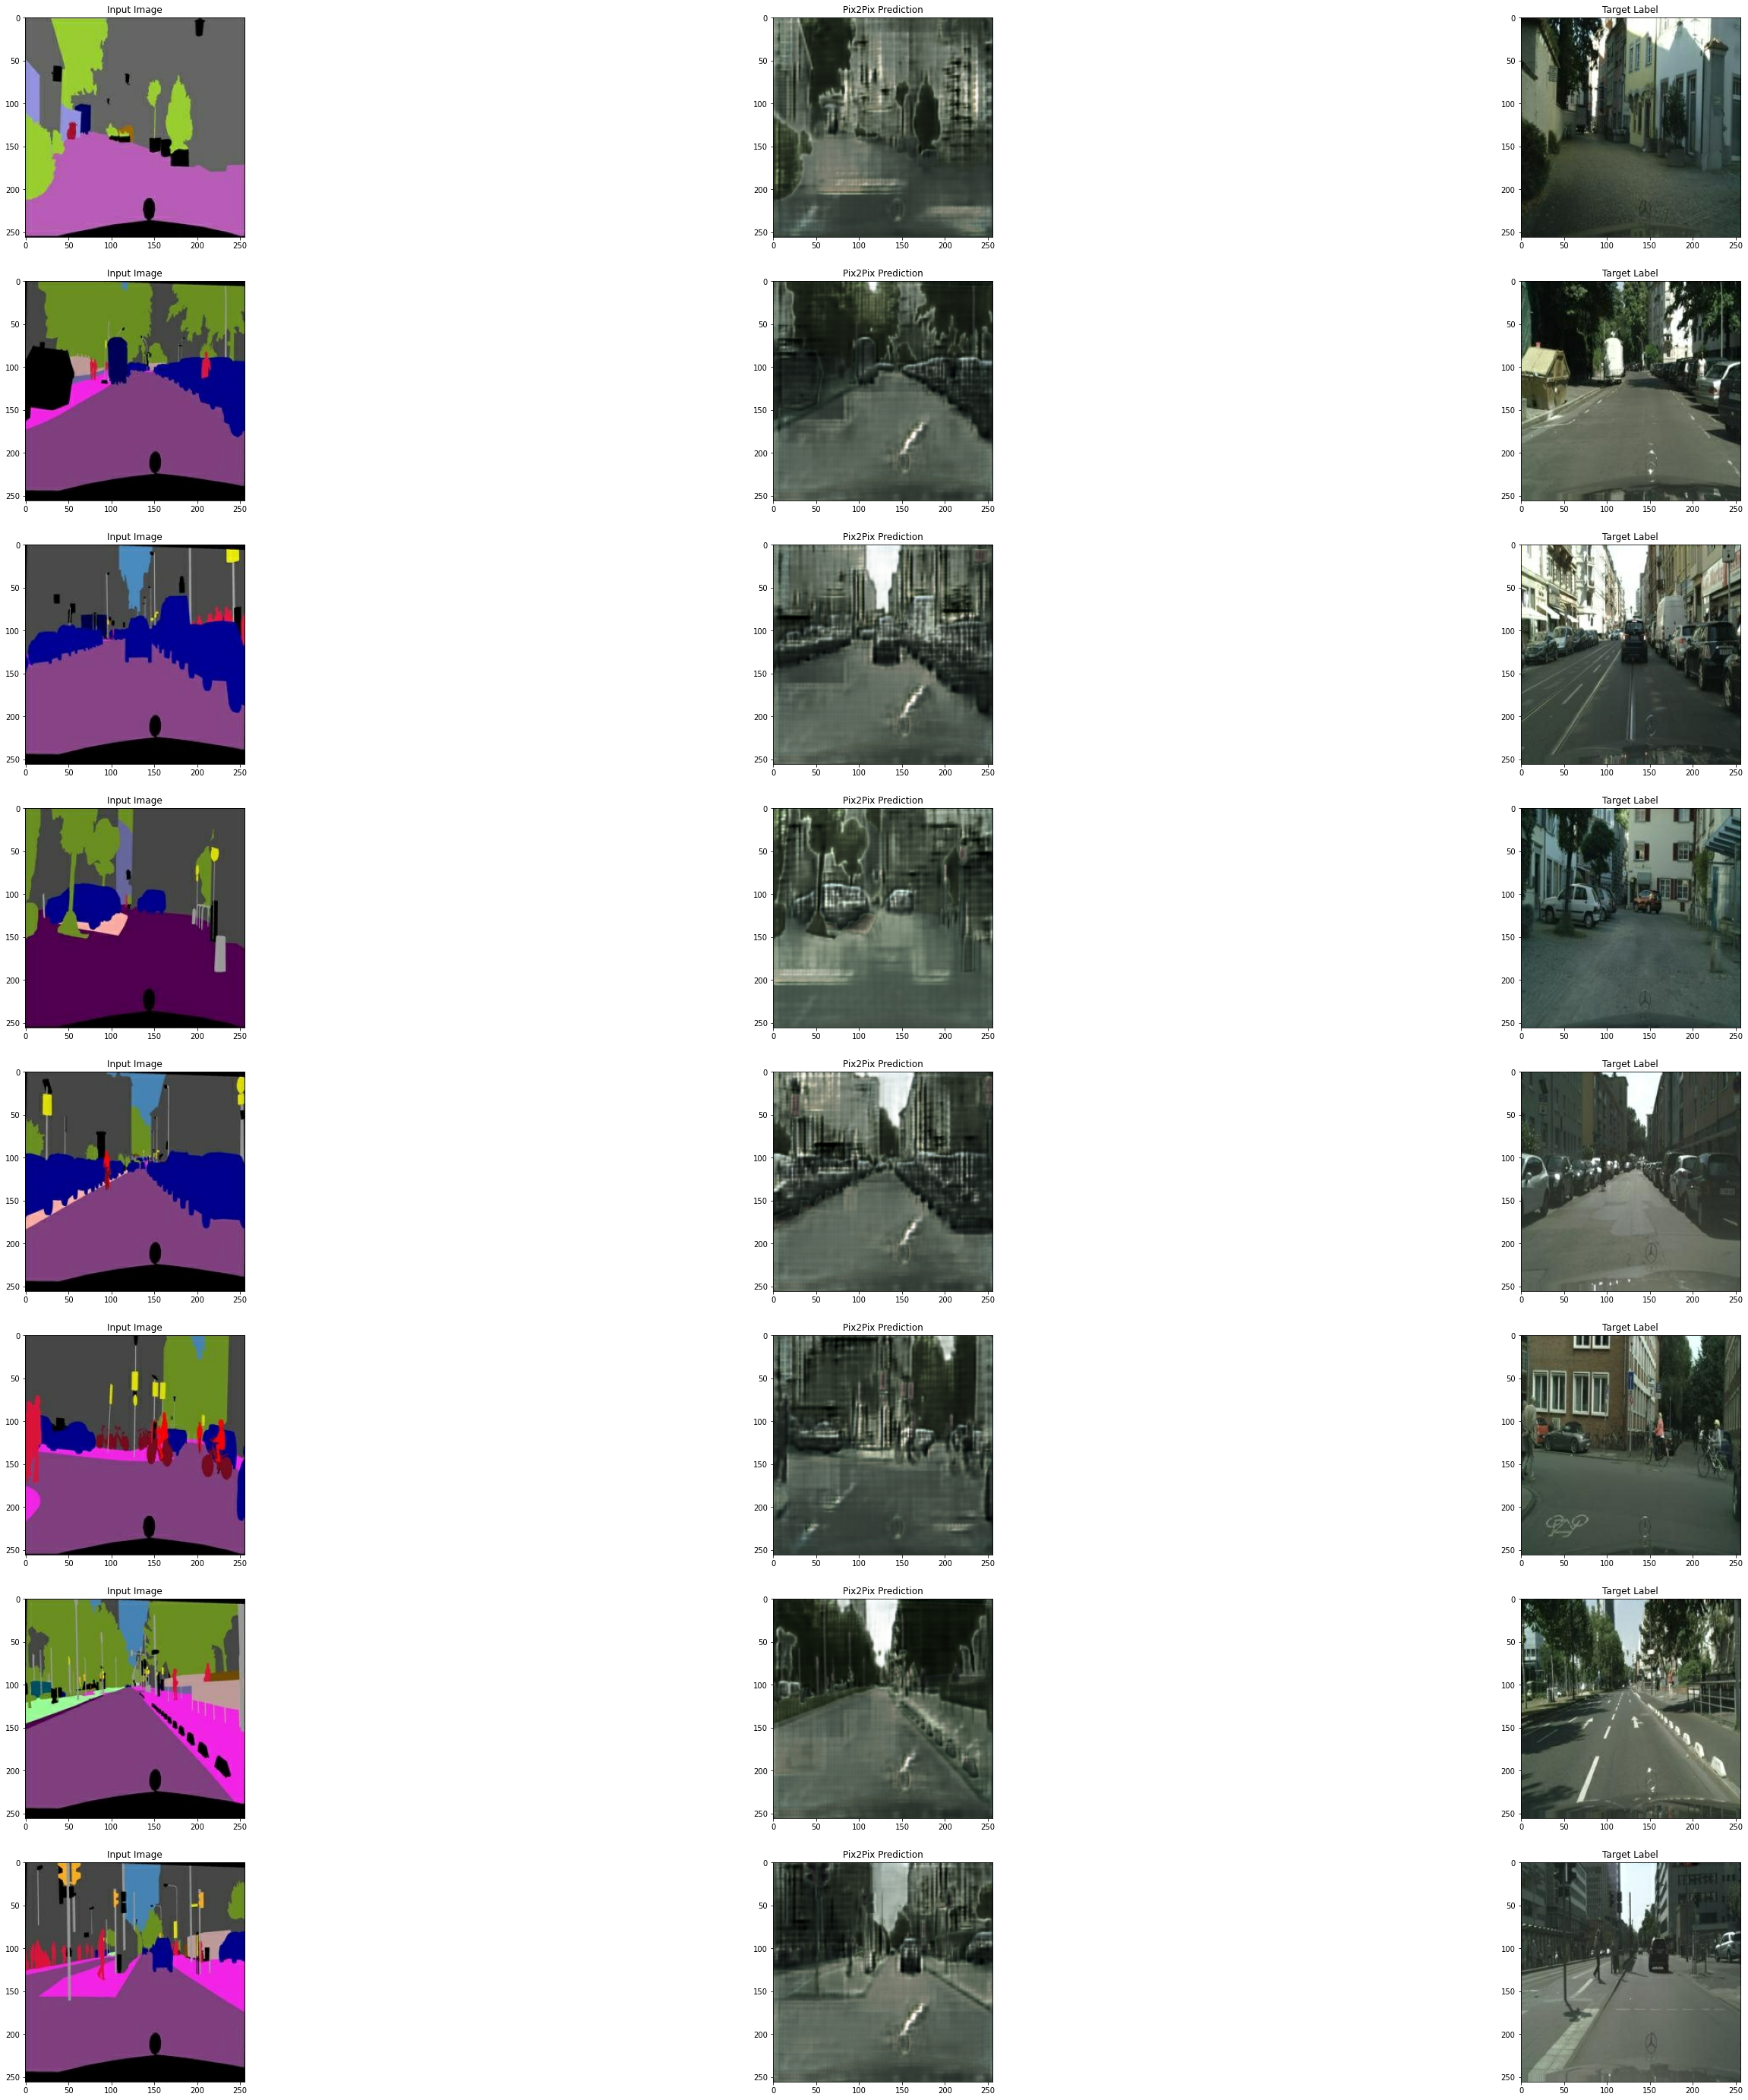

In [35]:
# plot the respective predictions
print("[INFO] saving the predictions...")
(fig, axes) = subplots(nrows=INFER_BATCH_SIZE, ncols=3,
    figsize=(50, 50))

# plot the predicted images 
for (ax, inp, pred, tgt) in zip(axes, inputMask, pix2pixGenPred,
    realImage):
    # plot the input mask image
    ax[0].imshow(array_to_img(inp))
    ax[0].set_title("Input Image")

    # plot the predicted Pix2Pix image
    ax[1].imshow(array_to_img(pred))
    ax[1].set_title("Pix2Pix Prediction")

    # plot the ground truth
    ax[2].imshow(array_to_img(tgt))
    ax[2].set_title("Target Label")

# check whether output image directory exists, if it doesn't, then
# create it
if not os.path.exists(BASE_IMAGES_PATH):
    os.makedirs(BASE_IMAGES_PATH)

# serialize the results to disk
print("[INFO] saving the pix2pix predictions to disk...")
fig.savefig(GRID_IMAGE_PATH)

REFERENCES:

Chakraborty, D. “Image Translation with Pix2Pix,” PyImageSearch, P. Chugh, A. R. Gosthipaty, S. Huot, K. Kidriavsteva, R. Raha, and A. Thanki, eds., 2022, https://pyimg.co/ma1qi

https://arxiv.org/pdf/1611.07004.pdf

